import packages

In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm 
from PIL import Image
import os
import cv2

Read the Ground Truth Labels

In [3]:
# load the csv file 

path = './data/labels.csv'

df = pd.read_csv(path)
df.head(5)

,Image_Name,"Classes(motorcycle, truck, boat, bus, cycle, , , , , , , sitar, ektara, flutes, tabla, harmonium)",motorcycle,truck,boat,bus,cycle,sitar,ektara,flutes,tabla,harmonium
0,image1.jpg,bus,0,0,0,1,0,0,0,0,0,0
1,image2.jpg,sitar,0,0,0,0,0,1,0,0,0,0
2,image3.jpg,flutes,0,0,0,0,0,0,0,1,0,0
3,image4.jpg,bus,0,0,0,1,0,0,0,0,0,0
4,image5.jpg,bus,0,0,0,1,0,0,0,0,0,0


In [7]:
# rename the second column

column_names = df.columns.to_list()

df.rename(columns= {column_names[1]:'Classes'},inplace=True)
df.head(5)

,Image_Name,Classes,motorcycle,truck,boat,bus,cycle,sitar,ektara,flutes,tabla,harmonium
0,image1.jpg,bus,0,0,0,1,0,0,0,0,0,0
1,image2.jpg,sitar,0,0,0,0,0,1,0,0,0,0
2,image3.jpg,flutes,0,0,0,0,0,0,0,1,0,0
3,image4.jpg,bus,0,0,0,1,0,0,0,0,0,0
4,image5.jpg,bus,0,0,0,1,0,0,0,0,0,0


In [8]:
# Extract the labels for the dataframe
labels = []
for index,row in df.iterrows():
    labels.append(list(row.iloc[-10:]))
print(labels[:5])

[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]


In [9]:
# convert the labels to numpy array
labels = np.array(labels)
labels.shape

(7943, 10)

Read the Images

In [12]:
# Get the image names from df
image_names = df['Image_Name'].tolist()
image_names[:5]

['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg']

In [20]:
# Extract the image file and attach the root path
images = []
path = './data/labels.csv'
root = ".\data\images"

# Fixe image shape to 224,224
target_size = (224,224)

for img_name in tqdm(image_names):
    image_path = os.path.join(root,img_name)
    image = Image.open(image_path).resize(target_size) # open and resize the image

    image = np.array(image) # conver image to numpy array

    # Ensure the image has 3 channels(if not convert grayscale to RGB)
    if image.ndim == 2: # grayscale image
        image = np.stack([image] * 3, axis = -1)

    images.append(image)
images = np.array(images)

100%|██████████| 7943/7943 [00:42<00:00, 186.99it/s]


In [23]:
images.shape

(7943, 224, 224, 3)

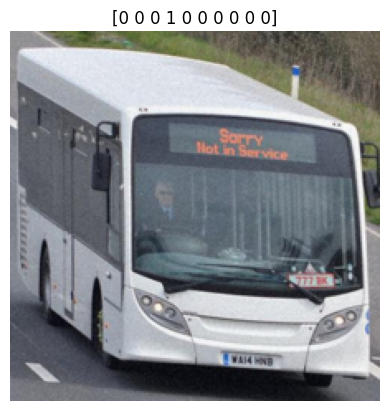

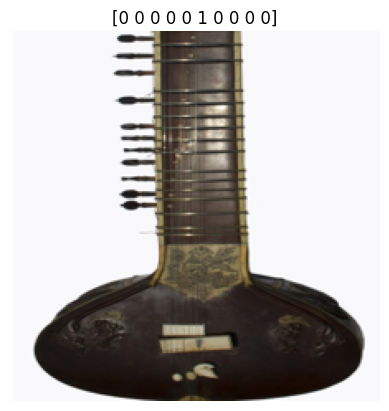

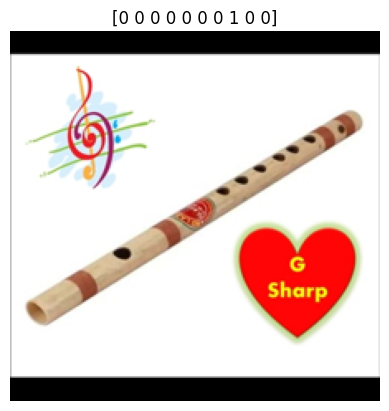

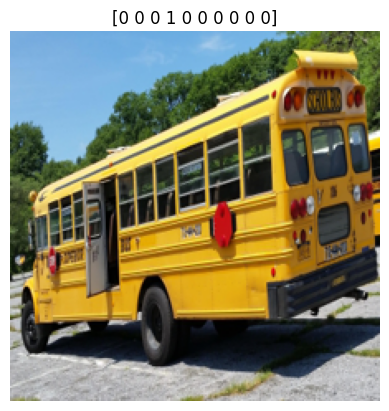

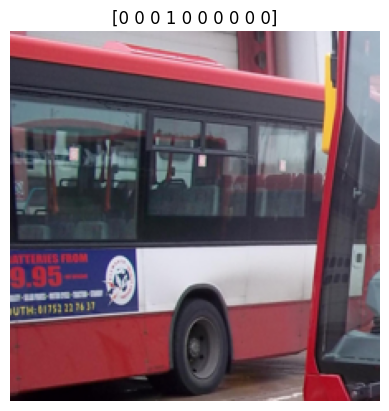

In [28]:
# Visulalize the images along with class labels

for idx,img in enumerate(images[:5]):
    plt.imshow(img)
    plt.title(labels[idx])
    plt.axis('off')
    plt.show()

Statistics of the Class Labels

In [31]:
# count the number of labels per class

ones_count_per_column = labels.sum(axis = 0)
ones_count_per_column

array([1339, 1015, 1671,  661, 1449,  401,  332,  554, 1480,  615])

In [35]:
df.columns[2:].tolist()

['motorcycle',
 'truck',
 'boat',
 'bus',
 'cycle',
 'sitar',
 'ektara',
 'flutes',
 'tabla',
 'harmonium']

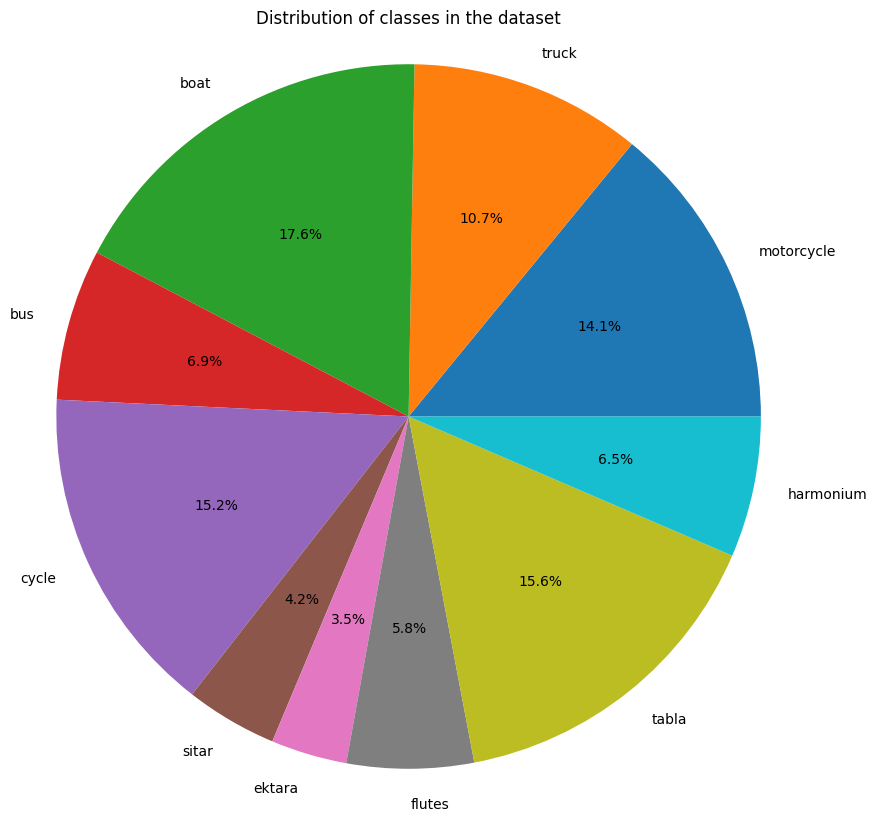

In [38]:
# plot a pie chart
plt.figure(figsize=(10,10))
plt.pie(ones_count_per_column,labels=df.columns[2:].tolist(),autopct='%.1f%%')
plt.title('Distribution of classes in the dataset')
plt.axis('equal') # equal aspect ratio ensures that pie is drawn as a circle
plt.show()

A Customized Pytorch Dataset Class

In [22]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

'''class Dataset(object):
    """_description_

    Args:
        object (_type_): _description_
    """
    def __getitem__(self,index):
        raise NotImplementedError
    
    def __len__(self):
        raise NotImplementedError
    
    def __add__(self,other):
        return ConcatDataset([self,other])'''

In [43]:
class MulitLabelDataset(Dataset):
    def __init__(self,labels_path,images_path,target_size):
        
        self.images, self.labels = [],[]

        self.X_train,self.X_val,self.X_test,self.y_train,self.y_val,self.y_test = None,None,None,None,None,None

        self.mode = 'train'

        # read the dataset
        df = pd.read_csv(labels_path)

       # get the columns names
        column_names = df.columns.to_list()

        # rename the second column
        df.rename(columns= {column_names[1]:'Classes'},inplace=True)

        # Extract the labels for the dataframe
        for index,row in df.iterrows():
            subset_l = list(row.iloc[-10:])
            self.labels.append(np.array(subset_l))
        self.labels = np.array(self.labels)

        # Extract the image file and attach the root path
        image_names = df['Image_Name'].tolist()
        for img_name in tqdm(image_names):
            image_path = os.path.join(images_path,img_name)
            image = Image.open(image_path)
            image = np.array(image) # conver image to numpy array
            # Ensure the image has 3 channels(if not convert grayscale to RGB)
            if image.ndim == 2:
                image = np.stack([image] * 3, axis = -1)
            image = cv2.resize(image,target_size) # resize the image to target size
            image = image.reshape((3,target_size[0],target_size[1])) # reshape the image to 3 x H x W
            self.images.append(image)
        self.images = np.array(self.images)

        # normalize the images
        self.normalize()

    def normalize(self):
        self.images = self.images / 255.0

    def train_val_test_split(self,test_size,val_size):
        self.X_train,self.X_test,self.y_train,self.y_test = train_test_split(self.images,self.labels,test_size= test_size,random_state=42)
        self.X_train,self.X_val,self.y_train,self.y_val = train_test_split(self.X_train,self.y_train,test_size=val_size,random_state=42)


    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
        elif self.mode == 'test':
            return self.X_test.shape[0]

    def __getitem__(self,idx):
        if self.mode == 'train':
            sample = {'image':self.X_train[idx],'label':self.y_train[idx]}
        elif self.mode == 'val':
            sample = {'image':self.X_val[idx],'label':self.y_val[idx]}
        elif self.mode == 'test':
            sample = {'image':self.X_test[idx],'label':self.y_test[idx]}
        return sample

In [44]:
path = '.\data\labels.csv'
root = ".\data\images"
dataset = MulitLabelDataset(labels_path=path,images_path=root,target_size=(224,224))

100%|██████████| 7943/7943 [00:37<00:00, 209.58it/s]


In [17]:
# dataset.images.shape
# len(dataset)
# to add two datasets we can use the ConcatDataset class, we don't need to override functionality 
# for that purpose as it is alredy implemented in the PyTorch Dataset class using __add__ dunder method
# Ex d2 = MulitLabelDataset() 
# d3 = MulitLabelDataset() 
# d4 = d2 + d3 

In [45]:
dataset.train_val_test_split(test_size=0.33,val_size=0.33)

In [47]:
dataset.mode = 'train'
len(dataset)

3565

DataLoaders

In [48]:
# import 
from torch.utils.data import DataLoader

In [49]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True,drop_last=True)


Creating a Convolutional Neural Network Model using ResNet18

In [52]:
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights

In [53]:
res_model = models.resnet18(weights=ResNet18_Weights.DEFAULT) # load the pretrained restnet18 model and intialize the weights

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\vamsi7/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.3MB/s]


In [72]:
res_model.fc # get a particular layer from the model, here last layer of the model

Linear(in_features=512, out_features=1000, bias=True)

In [73]:
res_model.fc.in_features # access particular attribute of the layer here in_features of last layer

512

In [74]:
res_model.fc.out_features

1000

Let's build our model

In [61]:
class MultiLabelClassification(nn.Module):
    def __init__(self,num_classes):
        super(MultiLabelClassification,self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.in_features,num_classes)
    
    def forward(self,x):
        return self.resnet(x)

In [62]:
model = MultiLabelClassification(num_classes=10)
model.resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
# lets check the requires_grad flag for the parameters
for name, param in model.resnet.named_parameters():
    print(name,param.requires_grad)


conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.downsample.0.weight True
layer2.0.downsample.1.weight True
layer2.0.downsample.1.bias True
layer2.1.conv1.weight True
layer2.1.bn1.weight True
layer2.1.bn1.bias True
layer2.1.conv2.weight True
layer2.1.bn2.weight True
layer2.1.bn2.bias True
layer3.0.conv1.weight True
layer3.0.bn1.weight True
layer3.0.bn1.bias True
layer3.0.conv2.weight True
layer3.0.bn2.weight True
layer3.0.bn2.bias True
layer3.0.downsample.0.weight True
layer3.0.downsample.1.weight True
layer3.0.downsample.1.bias True
la

In [71]:
# lets check the inside the parameters
for name, param in model.resnet.named_parameters():
    print(name, param.data)

conv1.weight tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01],
       

In [67]:
model.resnet.fc.weight # weight matrix for the last layer (fully connected layer)

Parameter containing:
tensor([[-5.0262e-03,  4.1330e-02,  1.7809e-02,  ..., -1.0014e-02,
          4.4226e-03,  1.4602e-02],
        [-3.8041e-02, -1.8337e-02, -6.0145e-05,  ...,  4.3755e-02,
          1.9246e-02,  1.7216e-02],
        [ 3.2130e-02, -3.7681e-02,  3.7621e-02,  ...,  2.4216e-02,
         -2.3794e-03, -2.2827e-02],
        ...,
        [-1.3059e-02, -3.8306e-02, -9.5928e-03,  ..., -4.0817e-02,
         -3.3077e-02,  5.7338e-03],
        [-3.9536e-02, -2.8561e-02,  1.5726e-02,  ..., -1.0139e-02,
         -3.2598e-02, -3.1769e-02],
        [-2.6131e-02,  4.3395e-02, -2.4720e-02,  ...,  5.0926e-03,
         -1.9321e-03, -1.3917e-02]], requires_grad=True)

In [69]:
model.resnet.fc.bias # bias for the last layer (fully connected layer)

Parameter containing:
tensor([ 0.0059, -0.0355,  0.0219,  0.0010,  0.0161, -0.0019, -0.0228,  0.0087,
         0.0238,  0.0069], requires_grad=True)

The Training Loop